### DATA SOURCE 

The data source for this project is the spreadsheet file *CSIRO_Recons_gmsl_yr_2019.csv*, which can be downloaded in the page of the article  <a href="https://www.cmar.csiro.au/sealevel/sl_hist_few_hundred.html" target="_blank">**“Historical Sea Level Changes”**</a> of the old CSIRO website. The exact download link is <a href="ftp://ftp.csiro.au/legresy/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv." target="_blank">*ftp://ftp.csiro.au/legresy/gmsl_files/CSIRO_Recons_gmsl_yr_2019.csv.*</a>

CSIRO stands for the Commonwealth Scientific and Industrial Research Organisation, a government agency in Australia that conducts scientific research. The spreedsheet file documents the **Global Mean Sea Level (GMSL)** in millimeters (mm) and the **GMSL uncertainty** in mm from **1880 to 2019**.


### DATA PROCESSING

Part of our data preprocessing is dropping the *GMSL uncertainty (mm)* columnn since we will be focusing on the values in the column **GMSL/Global Mean Sea Level in millimeters (mm)** from 1880 to 2019 in our project. We will ONLY be using these proper GMSL values for our predictions, so we disregard the uncertainty values.

Additionally, we also reformatted the values in the **Year** column by removing the fractional part **.5** at the end of the values under the Year column. Thus, 1880.5 was turned to 1880, 1881.5 to 1881, and so on and so forth. This is so we can better represent the exact years that the GMSL values were gathered from. 


In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("CSIRO_Recons_gmsl_yr_2019.csv", header=0, index_col=0)
df.drop(columns=["GMSL uncertainty (mm)"], axis=1, inplace=True)
df.index.names = ['Year']
df.rename(columns={"GMSL (mm)": "sea_level"}, inplace=True)

df.index = np.floor(df.index).astype(int)
# df.index = pd.to_datetime(df.index, format="%Y").year
df.head()

,sea_level
Year,
1880,-30.3
1881,-24.7
1882,-41.5
1883,-36.2
1884,-15.3


### EXPLORATORY DATA ANALYSIS

**ADF Test**\
Check if data is non-stationary. If p value > 0.05, find a suitable order of differencing.

In [2]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df["sea_level"].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.393374
p-value: 0.999007


c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


**Finding a suitable order of differencing**\
Since the p-value > 0.05, identify an order of differencing such that the plot of the differenced data is stationary. We observe that the plot of the first and second order differencing appear to be stationary compared to the original series. We choose the order differencing to be 2. 

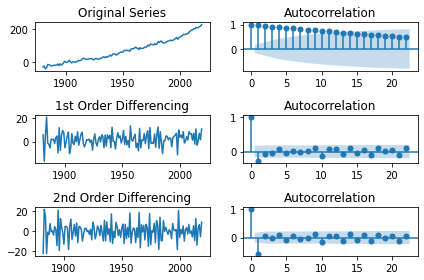

In [3]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df["sea_level"]); axes[0, 0].set_title('Original Series')
plot_acf(df["sea_level"], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df["sea_level"].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df["sea_level"].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df["sea_level"].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df["sea_level"].diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout()
plt.show()

**Find the order of the AR term (p)**\
We identify a possible order of the AR term by observing the partial autocorrelation plot of the second order differencing. We observe that the PACF lag 1 is quite significant since it is well below the significance line (past the blue shaded area). We take the order of the AR term to be 1.

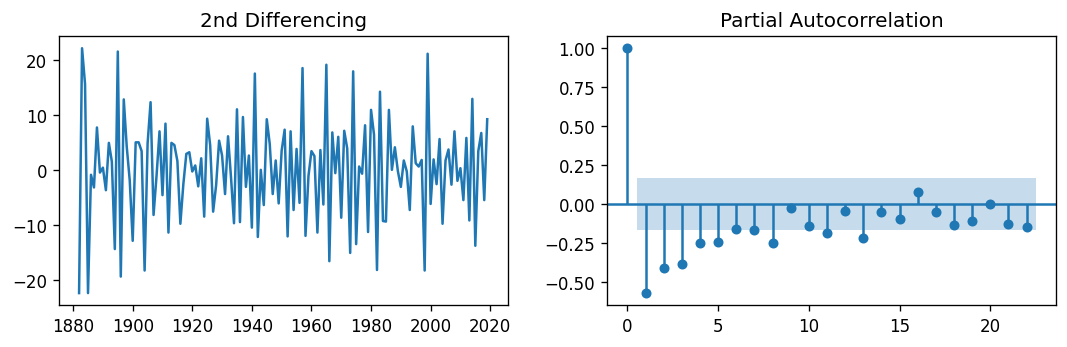

In [4]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
# axes[0].set_xlim([1880, 2019])
axes[0].plot(df["sea_level"].diff().diff()); axes[0].set_title('2nd Differencing')
plot_pacf(df["sea_level"].diff().diff().dropna(), ax=axes[1])

fig.tight_layout()
plt.show()

**Finding the order of the MA term (q)**\
We identify a possible order of the MA term by observing the autocorrelation plot of the second order differencing. We observe that the ACF lag 1 is quite significant since it is well below the significance line (past the blue shaded area). We take the order of the MA term to be 1.

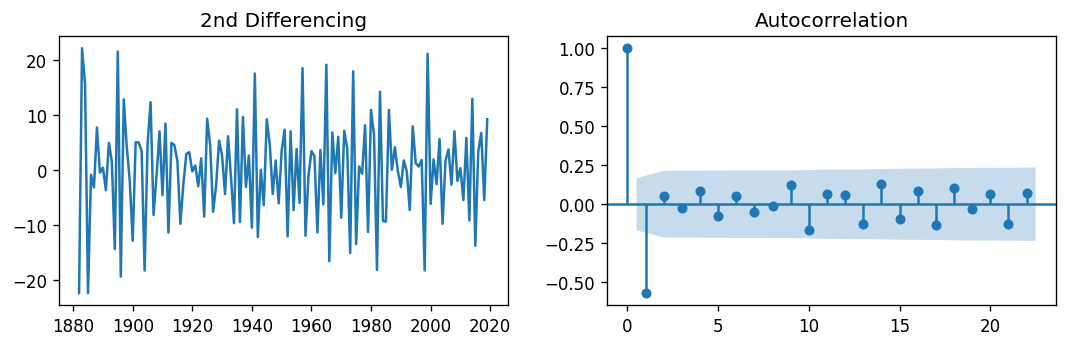

In [5]:
fig, axes = plt.subplots(1, 2)
axes[0].plot(df["sea_level"].diff().diff()); axes[0].set_title('2nd Differencing')
plot_acf(df["sea_level"].diff().diff().dropna(), ax=axes[1])
fig.tight_layout()
plt.show()

### MODELLING
Based on our exploratory data analysis, we have 2 to be the order of differencing (d), 1 to be the order of the AR term (p), and 1 to be the order of the MA term (q). We now use these values to build our ARIMA model.

In [6]:
from statsmodels.tsa.arima.model import ARIMA
# prepare training dataset
X = df.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
arima_model = None
predictions = list()
for t in range(len(test)):
    arima_model = ARIMA(history, order=(1,2,1))
    arima_model_fit = arima_model.fit()
    yhat = arima_model_fit.forecast()[0]
    predictions.append(yhat)
    history.append(test[t])

print(arima_model_fit.summary())

NameError: name 'ARIMA' is not defined

### Results and Discussion

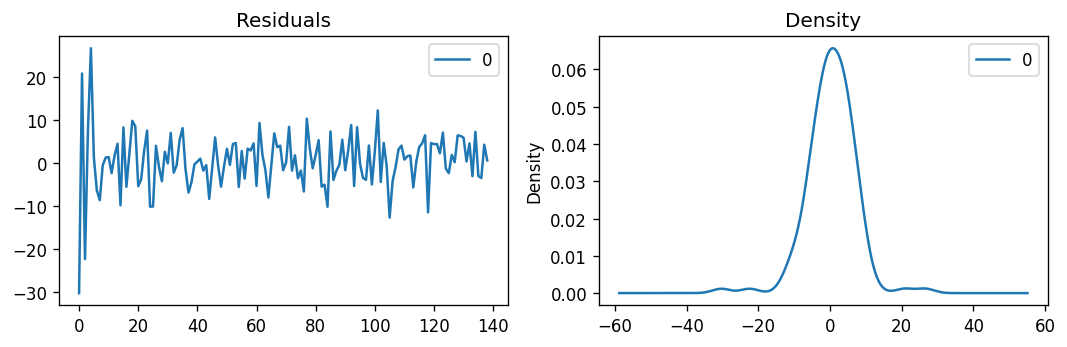

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(arima_model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
fig.tight_layout()
plt.show()

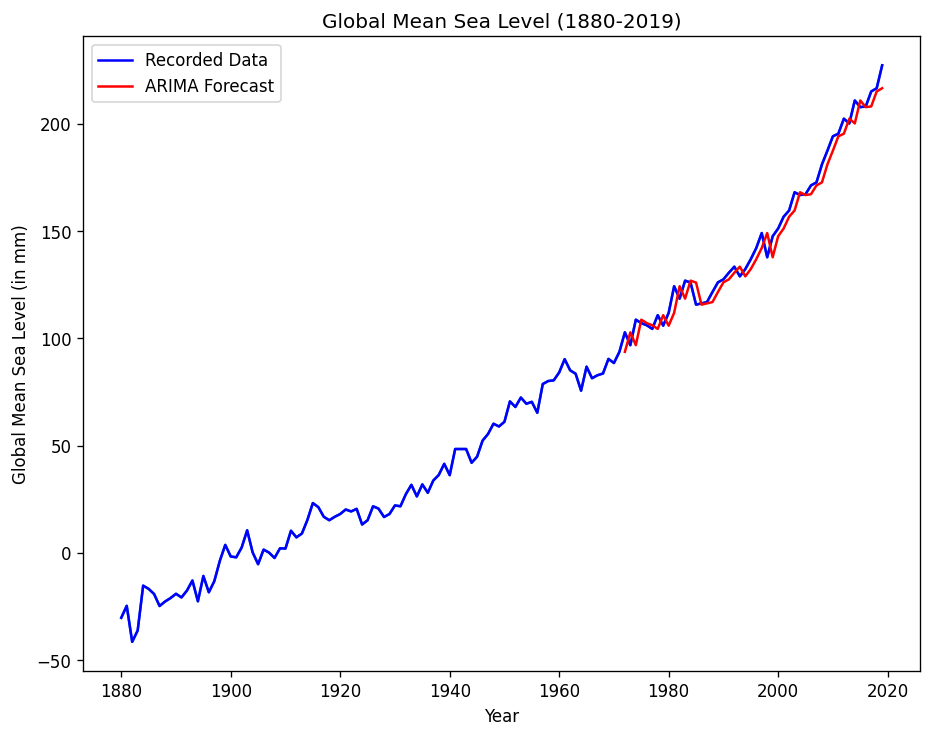

In [ ]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

plt.plot(df["sea_level"])

x = [i for i in range(1972, 2020)]
y = predictions
plt.plot(df["sea_level"], label='Recorded Data', color='blue')
plt.plot(x, y, label='ARIMA Forecast', color='red')

# Labelling 

plt.xlabel("Year")
plt.ylabel("Global Mean Sea Level (in mm)")
plt.title("Global Mean Sea Level (1880-2019)")

# Display
plt.legend()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    # acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(np.array([[i] for i in predictions]), test)

{'mape': 0.03595982634597398,
 'me': -2.783333333333333,
 'mae': 5.058333333333331,
 'mpe': -0.017433683191147294,
 'rmse': 6.113543707757936,
 'corr': nan,
 'minmax': 0.03546740852707275}

In [ ]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    model = None
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return model, predictions, rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_arima, best_predictions, best_score, best_cfg = None, None, float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    current_arima, current_predictions, rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_arima, best_predictions, best_score, best_cfg = current_arima, current_predictions, rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_arima, best_predictions
 
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
best_arima, best_predictions = evaluate_models(df.values, p_values, d_values, q_values)

c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


ARIMA(0, 0, 0) RMSE=106.475
ARIMA(0, 0, 1) RMSE=57.321
ARIMA(0, 0, 2) RMSE=34.701
ARIMA(0, 1, 0) RMSE=6.114
ARIMA(0, 1, 1) RMSE=6.234
ARIMA(0, 1, 2) RMSE=6.262
ARIMA(0, 2, 0) RMSE=8.882
ARIMA(0, 2, 1) RMSE=5.590
ARIMA(0, 2, 2) RMSE=5.357
ARIMA(1, 0, 0) RMSE=6.234
ARIMA(1, 0, 1) RMSE=6.339
ARIMA(1, 0, 2) RMSE=6.365
ARIMA(1, 1, 0) RMSE=6.145
ARIMA(1, 1, 1) RMSE=6.252
ARIMA(1, 1, 2) RMSE=5.866
ARIMA(1, 2, 0) RMSE=6.793
ARIMA(1, 2, 1) RMSE=5.308
ARIMA(1, 2, 2) RMSE=5.626
ARIMA(2, 0, 0) RMSE=6.253
ARIMA(2, 0, 1) RMSE=6.301
ARIMA(2, 0, 2) RMSE=6.503
ARIMA(2, 1, 0) RMSE=6.287
ARIMA(2, 1, 1) RMSE=6.261
ARIMA(2, 1, 2) RMSE=6.255
ARIMA(2, 2, 0) RMSE=5.995
ARIMA(2, 2, 1) RMSE=5.395
ARIMA(2, 2, 2) RMSE=5.482
ARIMA(4, 0, 0) RMSE=6.448
ARIMA(4, 0, 1) RMSE=6.735
ARIMA(4, 0, 2) RMSE=6.726
ARIMA(4, 1, 0) RMSE=6.372
ARIMA(4, 1, 1) RMSE=5.672
ARIMA(4, 2, 0) RMSE=6.362
ARIMA(4, 2, 1) RMSE=5.676
ARIMA(4, 2, 2) RMSE=5.858
ARIMA(6, 0, 1) RMSE=16.627
ARIMA(6, 0, 2) RMSE=6.707
ARIMA(6, 1, 0) RMSE=6.238
ARIMA(6

In [ ]:
best_arima_fit = best_arima.fit()
print(best_arima_fit.summary())

NameError: name 'best_arima' is not defined

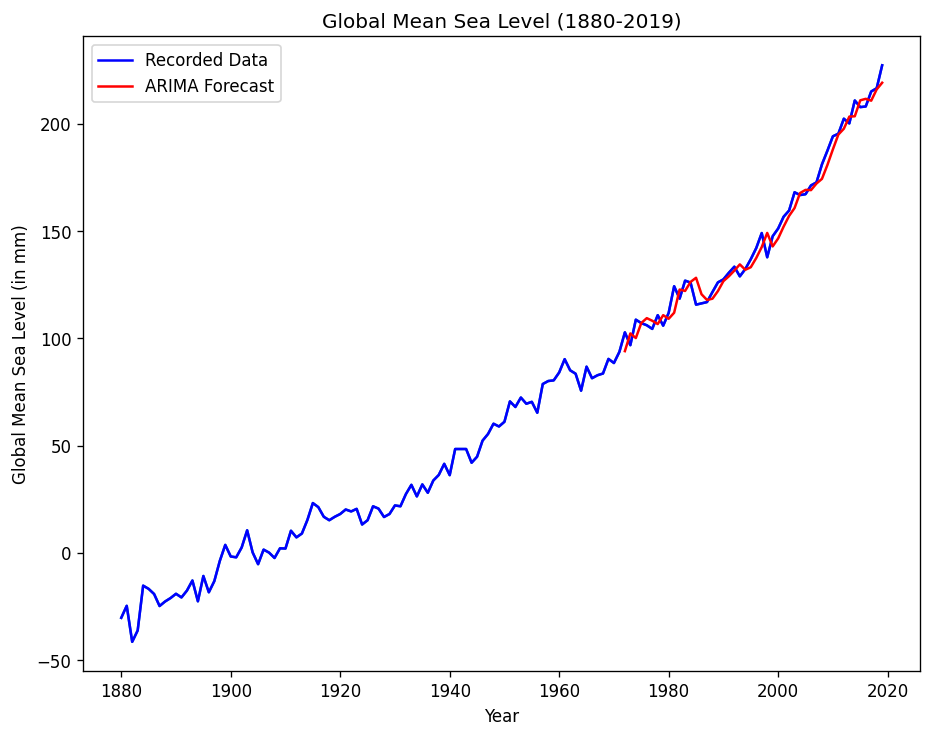

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

plt.plot(df["sea_level"])

x = [i for i in range(1972, 2020)]
y = best_predictions
plt.plot(df["sea_level"], label='Recorded Data', color='blue')
plt.plot(x, y, label='ARIMA Forecast', color='red')

# Labelling 

plt.xlabel("Year")
plt.ylabel("Global Mean Sea Level (in mm)")
plt.title("Global Mean Sea Level (1880-2019)")

# Display
plt.legend()
plt.show()

### CONCLUSION